In [11]:
import os, json, time
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from glob import glob
import pandas as pd
from sklearn.metrics import confusion_matrix

In [12]:

# Load config
with open("../experiments/exp5/config.json") as f:
    config = json.load(f)

original_dir = config["original_dir"]
cartoon_dir = config["cartoon_dir"]
val_original_dir = config["val_original_dir"]
val_cartoon_dir = config["val_cartoon_dir"]
batch_size = config["batch_size"]
lambda_l1 = config["lambda_l1"]
learning_rate = config["learning_rate"]
limit = config["limit"]
beta1, beta2 = config["beta1"], config["beta2"]

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [14]:
# Dataset
class CartoonDataset(Dataset):
    def __init__(self, original_dir, cartoon_dir, transform=None, limit=None):
        self.original_paths = sorted(glob(os.path.join(original_dir, "*.png")))
        self.cartoon_paths = sorted(glob(os.path.join(cartoon_dir, "*.png")))
        if limit:
            self.original_paths = self.original_paths[:limit]
            self.cartoon_paths = self.cartoon_paths[:limit]
        self.transform = transform

    def __len__(self):
        return len(self.original_paths)

    def __getitem__(self, idx):
        real = Image.open(self.original_paths[idx]).convert("RGB")
        cartoon = Image.open(self.cartoon_paths[idx]).convert("RGB")
        if self.transform:
            real = self.transform(real)
            cartoon = self.transform(cartoon)
        return real, cartoon

In [15]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [16]:
train_loader = DataLoader(CartoonDataset(original_dir, cartoon_dir, transform, limit), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(CartoonDataset(val_original_dir, val_cartoon_dir, transform, limit), batch_size=batch_size, shuffle=False)

In [17]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU()
        )
        self.middle = nn.Sequential(
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()
        )

    def forward(self, x):
        return self.decoder(self.middle(self.encoder(x)))

In [18]:

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 4, 1, 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [19]:
# Setup
generator = Generator().to(device)
discriminator = Discriminator().to(device)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, beta2))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, beta2))
adversarial_loss = nn.BCELoss()
content_loss = nn.L1Loss()

In [25]:

g_losses, d_losses, d_accuracies = [], [], []
val_g_losses, val_d_losses, val_accuracies = [], [], []
start_epoch = 0

In [56]:
#comment this while running it for first time

if os.path.exists("../experiments/exp5/losses/losses.json"):
    with open("../experiments/exp5/losses/losses.json", "r") as f:
        losses = json.load(f)
        g_losses = losses.get("g_losses", [])
        d_losses = losses.get("d_losses", [])
        d_accuracies = losses.get("d_accuracies", [])
        val_g_losses = losses.get("val_g_losses", [])
        val_d_losses = losses.get("val_d_losses", [])
        val_accuracies = losses.get("val_accuracies", [])


In [51]:
# Load from checkpoint
checkpoint = torch.load("../experiments/exp5/checkpoints/cartoongan_epoch40.pth", weights_only=True)

generator.load_state_dict(checkpoint["generator"])
discriminator.load_state_dict(checkpoint["discriminator"])
g_optimizer.load_state_dict(checkpoint["g_optimizer"])
d_optimizer.load_state_dict(checkpoint["d_optimizer"])
start_epoch = checkpoint["epoch"]

In [52]:
# Training
for epoch in range(start_epoch, start_epoch + 10):
    start_time = time.time() 
    generator.train()
    discriminator.train()
    g_epoch_loss = 0
    d_epoch_loss = 0
    accuracy_accum = 0
    batch_count = 0

    for real, cartoon in train_loader:
        real, cartoon = real.to(device), cartoon.to(device)

        # Discriminator
        fake = generator(real).detach()
        d_real = discriminator(cartoon)
        d_fake = discriminator(fake)
        real_labels = torch.ones_like(d_real)
        fake_labels = torch.zeros_like(d_fake)
        d_loss = 0.5 * (adversarial_loss(d_real, real_labels) + adversarial_loss(d_fake, fake_labels))
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Accuracy
        pred_real = (d_real.mean(dim=[1, 2, 3]) > 0.5).float()
        pred_fake = (d_fake.mean(dim=[1, 2, 3]) < 0.5).float()
        correct = pred_real.sum().item() + pred_fake.sum().item()
        accuracy_accum += correct / (pred_real.numel() + pred_fake.numel())
        batch_count += 1

        # Generator
        fake = generator(real)
        g_adv = adversarial_loss(discriminator(fake), real_labels)
        g_l1 = content_loss(fake, cartoon)
        g_loss = g_adv + lambda_l1 * g_l1
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        g_epoch_loss += g_loss.item()
        d_epoch_loss += d_loss.item()

    # Logging
    g_losses.append(g_epoch_loss / len(train_loader))
    d_losses.append(d_epoch_loss / len(train_loader))
    d_accuracies.append(accuracy_accum / batch_count)

    # ✅ Validation Accuracy
    generator.eval()
    discriminator.eval()
    val_correct = 0
    val_total = 0
    val_g_loss_total = 0
    val_d_loss_total = 0
    with torch.no_grad():
        for real, cartoon in val_loader:
            real, cartoon = real.to(device), cartoon.to(device)

            fake = generator(real)
            d_real = discriminator(cartoon)
            d_fake = discriminator(fake)
            
            pred_real = (d_real.mean(dim=[1, 2, 3]) > 0.5).float()
            pred_fake = (d_fake.mean(dim=[1, 2, 3]) < 0.5).float()
            val_correct += pred_real.sum().item() + pred_fake.sum().item()
            val_total += pred_real.numel() + pred_fake.numel()

            # print("fake:", fake.shape)
            # print("disc(fake):", discriminator(fake).shape)
            # print("real_labels:", real_labels.shape)
             # Validation losses
            real_labels = torch.ones_like(d_real)
            fake_labels = torch.zeros_like(d_fake)
            d_loss_real = adversarial_loss(d_real, real_labels)
            d_loss_fake = adversarial_loss(d_fake, fake_labels)
            d_loss = (d_loss_real + d_loss_fake) * 0.5
            val_d_loss_total += d_loss.item()

            g_adv = adversarial_loss(discriminator(fake), real_labels)
            g_l1 = content_loss(fake, cartoon)
            g_loss = g_adv + lambda_l1 * g_l1
            val_g_loss_total += g_loss.item()
            

    val_acc = val_correct / val_total
    val_accuracies.append(val_acc)
    val_g_losses.append(val_g_loss_total / len(val_loader))
    val_d_losses.append(val_d_loss_total / len(val_loader))

    # ✅ Confusion Matrix
    if (epoch + 1) % 10 == 0:
        all_labels, all_preds = [], []
        with torch.no_grad():
            for real, cartoon in val_loader:
                real, cartoon = real.to(device), cartoon.to(device)
                d_real = discriminator(cartoon)
                d_fake = discriminator(generator(real))
                preds_real = (d_real.mean(dim=[1, 2, 3]) > 0.5).int().cpu().numpy()
                preds_fake = (d_fake.mean(dim=[1, 2, 3]) > 0.5).int().cpu().numpy()
                labels_real = torch.ones_like(d_real.mean(dim=[1, 2, 3])).int().cpu().numpy()
                labels_fake = torch.zeros_like(d_fake.mean(dim=[1, 2, 3])).int().cpu().numpy()
                all_preds.extend(preds_real)
                all_preds.extend(preds_fake)
                all_labels.extend(labels_real)
                all_labels.extend(labels_fake)
        cm = confusion_matrix(all_labels, all_preds)
        cm_df = pd.DataFrame(cm, index=["Fake", "Real"], columns=["Pred Fake", "Pred Real"])
        cm_df.to_csv(f"../experiments/exp5/logs/confusion_epoch_{epoch+1}.csv")

    end_time = time.time() 
    epoch_time = end_time - start_time 
    
    print(
    f"Epoch {epoch+1} | "
    f"t_g_Loss: {g_losses[-1]:.4f} | "
    f"t_d_Loss: {d_losses[-1]:.4f} | "
    f"t_Acc: {d_accuracies[-1]:.4f} | "
    f"v_g_Loss: {val_g_losses[-1]:.4f} | "
    f"v_d_Loss: {val_d_losses[-1]:.4f} | "
    f"v_Acc: {val_accuracies[-1]:.4f} | "
    f"Time: {epoch_time:.2f}s"
)
    # Save losses
    with open("../experiments/exp5/losses/losses.json", "w") as f:
        json.dump({
            "g_losses": g_losses,
            "d_losses": d_losses,
            "d_accuracies": d_accuracies,
            "val_g_losses" : val_g_losses,
            "val_d_losses" : val_d_losses,
            "val_accuracies": val_accuracies
        }, f)

    if (epoch + 1) % 10 == 0:
        torch.save({
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'g_optimizer': g_optimizer.state_dict(),
            'd_optimizer': d_optimizer.state_dict(),
            'epoch': epoch + 1
        }, f"../experiments/exp5/checkpoints/cartoongan_epoch{epoch+1}.pth")

    

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Plot Generator Loss
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator Loss", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator Loss Over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Discriminator Loss
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Discriminator Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Discriminator Loss Over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(d_accuracies, label="Discriminator Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Discriminator Accuracy Over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show

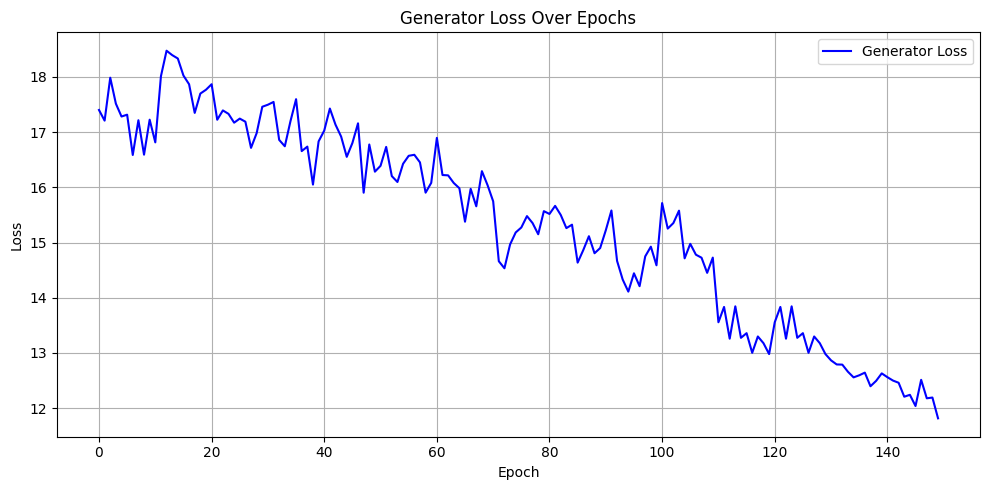

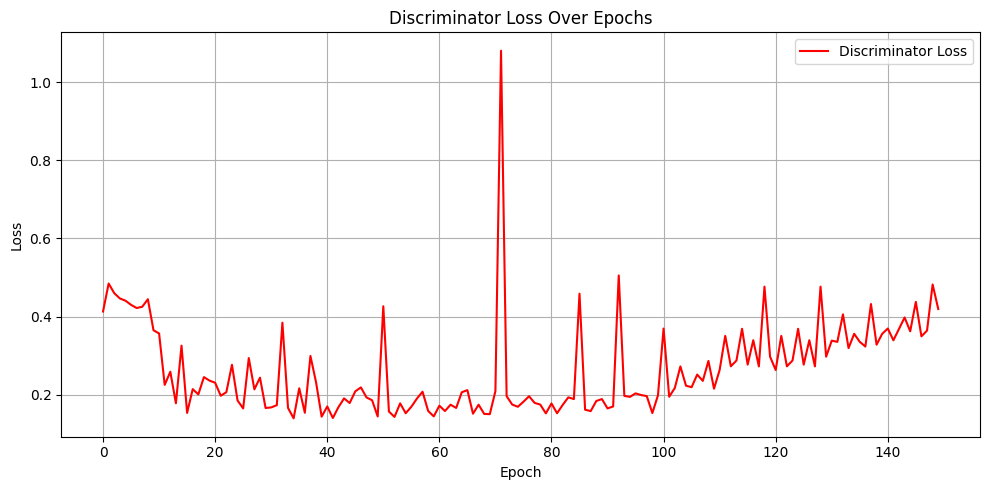

<function matplotlib.pyplot.show(close=None, block=None)>

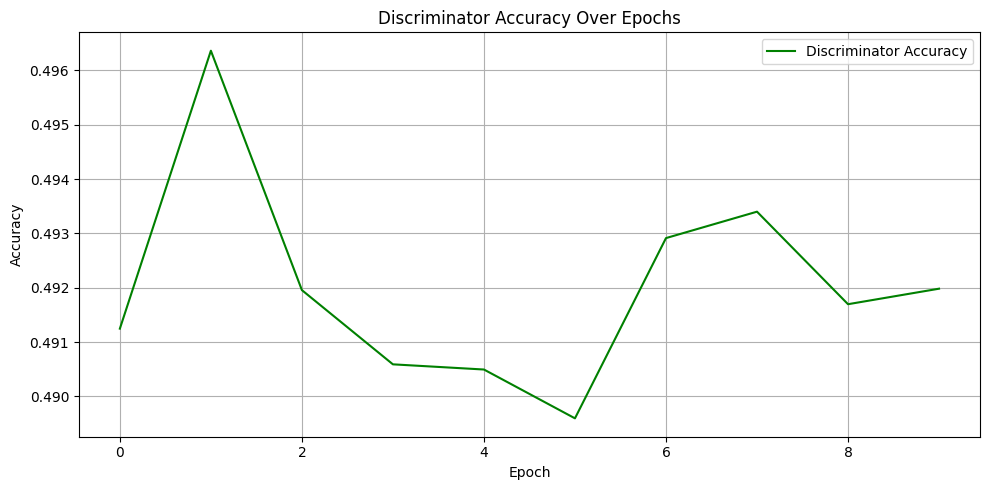

In [57]:
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator Loss", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator Loss Over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Discriminator Loss
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Discriminator Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Discriminator Loss Over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(d_accuracies, label="Discriminator Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Discriminator Accuracy Over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show

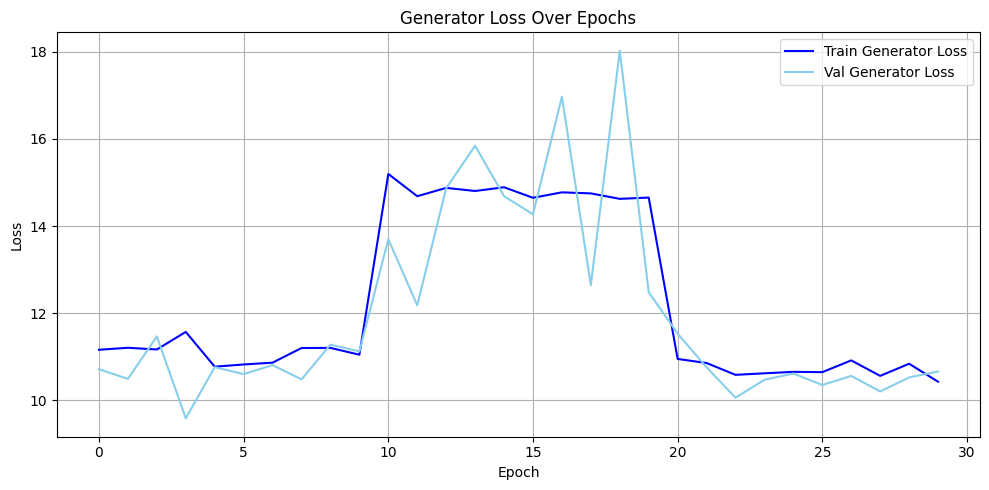

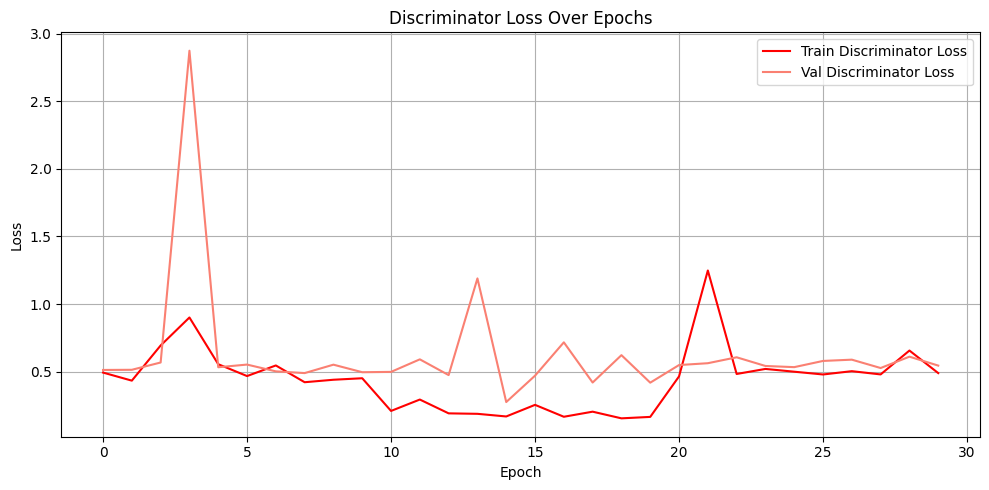

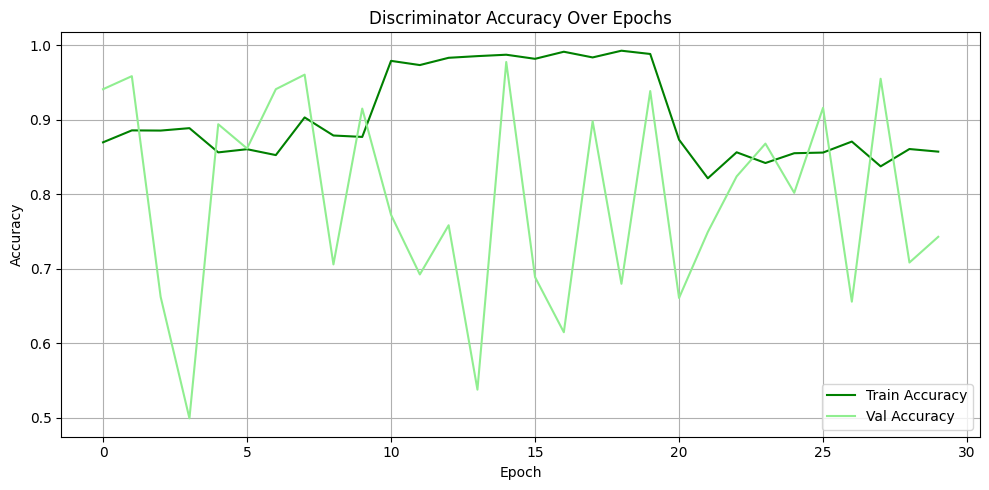

In [34]:

import matplotlib.pyplot as plt
# Plot Generator Training Loss
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Train Generator Loss", color='blue')
plt.plot(val_g_losses, label="Val Generator Loss", color='skyblue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator Loss Over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Discriminator Training Loss
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Train Discriminator Loss", color='red')
plt.plot(val_d_losses, label="Val Discriminator Loss", color='salmon')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Discriminator Loss Over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Discriminator Accuracy
plt.figure(figsize=(10, 5))
plt.plot(d_accuracies, label="Train Accuracy", color='green')
plt.plot(val_accuracies, label="Val Accuracy", color='lightgreen')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Discriminator Accuracy Over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


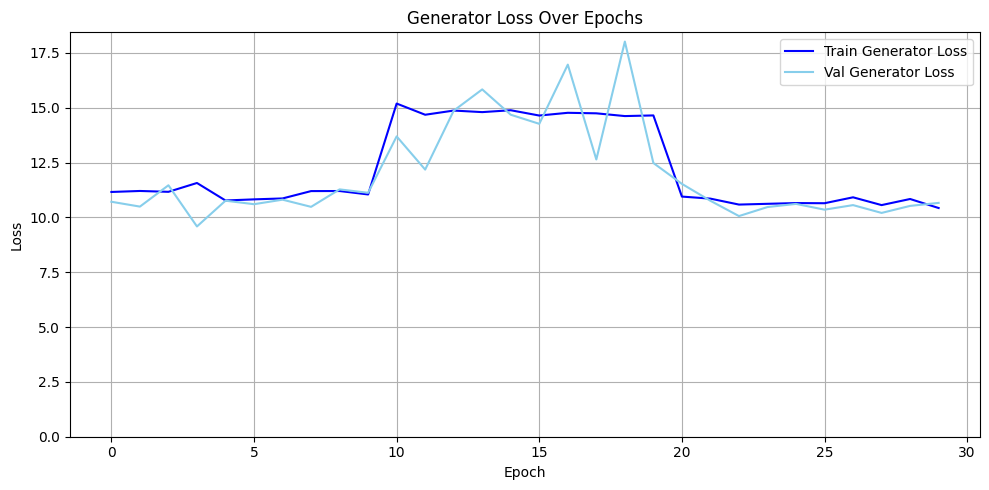

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Train Generator Loss", color='blue')
plt.plot(val_g_losses, label="Val Generator Loss", color='skyblue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator Loss Over Epochs")
plt.ylim(bottom=0)  # Start y-axis from 0
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


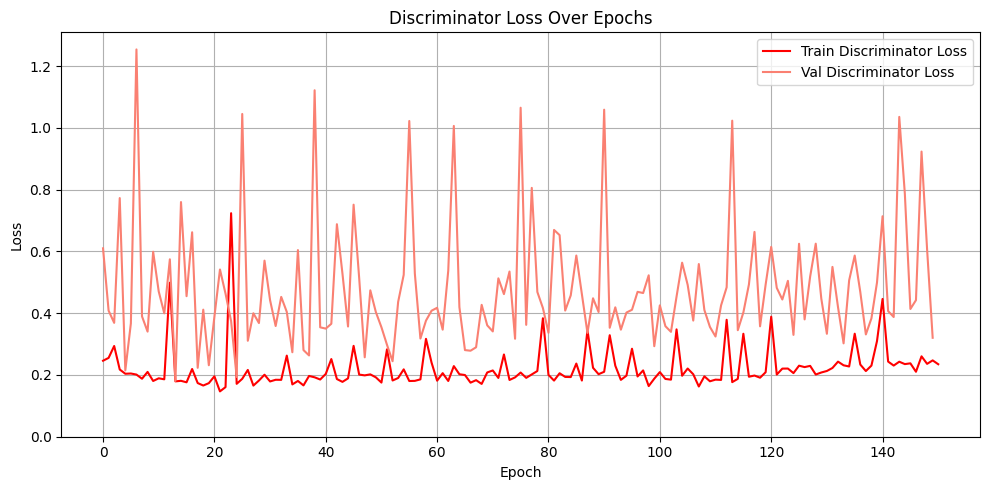

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Train Discriminator Loss", color='red')
plt.plot(val_d_losses, label="Val Discriminator Loss", color='salmon')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Discriminator Loss Over Epochs")
plt.ylim(bottom=0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '../experiments/exp5/logs/confusion_epoch_50.csv'

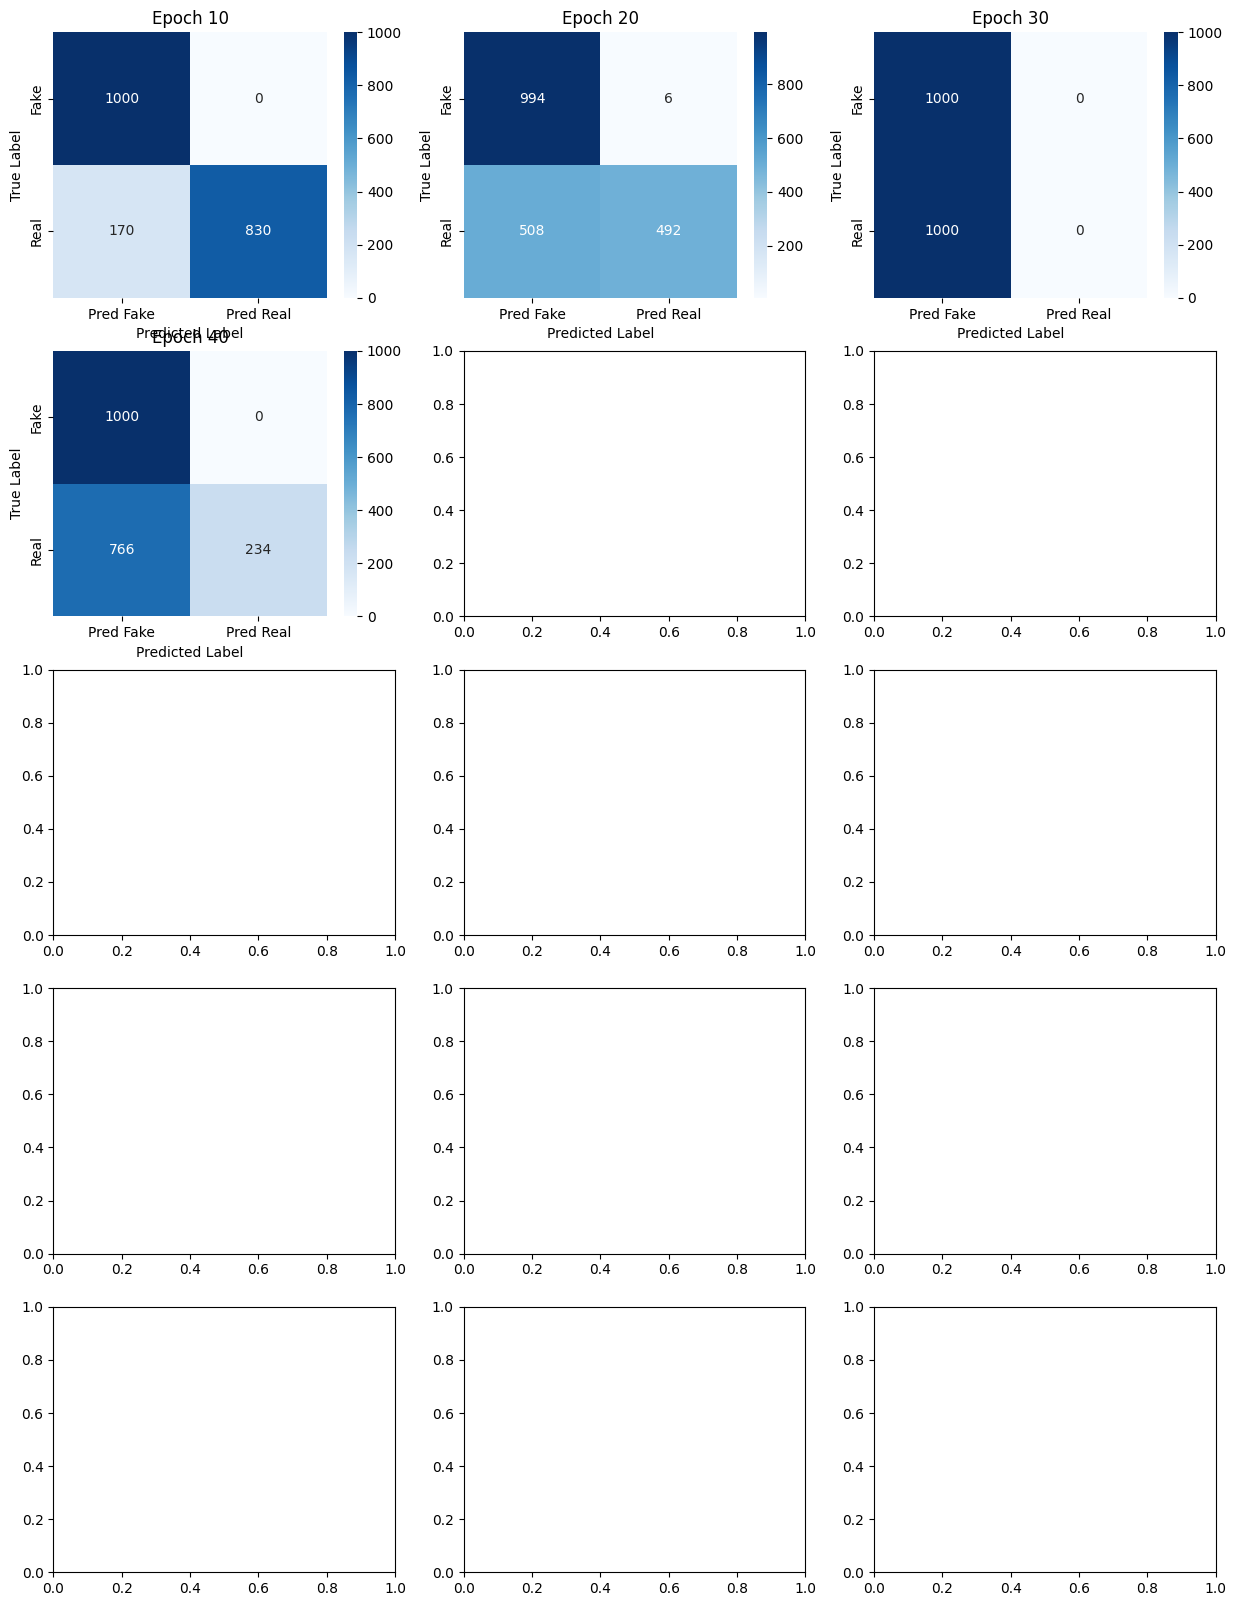

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math

# List of epochs to visualize
epochs = list(range(10, 160, 10))

# Grid setup: 3 plots per row
cols = 3
rows = math.ceil(len(epochs) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))

# Flatten axes for easy indexing
axes = axes.flatten()

for i, epoch in enumerate(epochs):
    cm_df = pd.read_csv(f"../experiments/exp4/logs/confusion_epoch_{epoch}.csv", index_col=0)
    ax = axes[i]
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f"Epoch {epoch}")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

# Hide any unused subplots
for j in range(len(epochs), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Confusion Matrices Over Epochs", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
